# 01 – Exploração do Snapshot

Primeiro notebook do **creditlab**.

Nele, vamos:
1. Instanciar o `CreditDataSynthesizer`.
2. Gerar a *safra 0* (snapshot) para alguns grupos homogêneos.
3. Fazer uma exploração inicial: contagem de contratos por grupo, estatísticas descritivas e um histograma de dias em atraso.

⚠️ Este notebook assume que o módulo `credit_data_synthesizer.py` está no mesmo diretório ou em `PYTHONPATH`.

In [1]:
import sys
from pathlib import Path

# Adiciona o diretório-pai ao sys.path
sys.path.append(str(Path().resolve().parent))

import pandas as pd
import matplotlib.pyplot as plt


from importlib import reload
import credit_data_synthesizer as cds
reload(cds)  # garante versão atual no notebook

from credit_data_synthesizer import (
    CreditDataSynthesizer,
    default_group_profiles,   # função helper já incluída no módulo
)

from credit_data_sampler import (
    TargetSampler
)

## Parâmetros iniciais

In [ ]:
# ----- parâmetros que você quer -----
n_groups = 10
contracts_per_group = 5_000
n_safras = 36
seed = 0

# 1) Obtenha os perfis padrão e pegue só os três primeiros
group_profiles = default_group_profiles(n_groups)

# 2) Instancie o sintetizador
synth = CreditDataSynthesizer(
    group_profiles=group_profiles,
    contracts_per_group=contracts_per_group,
    n_safras=n_safras,
    random_seed=24,
    start_safra = 202001
)

## Geração da safra 0

In [ ]:
# 3) Gere os dados
df_snapshot, df_panel, df_trace = synth.generate()

print(f"Snapshot gerado com {len(df_snapshot):,} linhas")
print(f"Painel gerado com {len(df_panel):,} linhas")
print(f"Rastro gerado com {len(df_trace):,} linhas")
display(df_snapshot.head())

Snapshot gerado com 200,000 linhas
Snapshot gerado com 7,200,000 linhas
Snapshot gerado com 37,363 linhas


,id_contrato,id_cliente,grupo_homogeneo,data_inicio_contrato,data_ref,safra,dias_atraso,nivel_refinanciamento,idade_cliente,sexo,...,valor_liberado,saldo_devedor,valor_parcela,num_parcelas_pagas,data_ult_pgt,score_latente,ever90m12,over90m12,flag_cura,subcluster
0,0,1382675336,GH1,2024-11-21,2020-01-01,202001,60,0,19,M,...,27553.328125,27553.328125,1048.461792,1,2024-12-21,0.117973,0,0,0,0
1,1,1330268836,GH1,2024-09-27,2020-01-01,202001,30,0,71,F,...,21345.406250,21345.406250,742.517334,1,2024-10-27,0.316219,1,0,0,11
2,2,1751192118,GH1,2024-10-16,2020-01-01,202001,30,0,40,M,...,30305.205078,30305.205078,803.447083,2,2024-12-15,-1.527140,0,0,0,13
3,3,1405177315,GH1,2024-08-23,2020-01-01,202001,0,0,72,F,...,12958.853516,12958.853516,899.893005,2,2024-10-22,0.483155,0,0,0,3
4,4,1784646613,GH1,2024-11-27,2020-01-01,202001,30,0,61,F,...,2771.985352,2771.985352,137.870010,2,2025-01-26,0.657599,0,0,0,11


In [4]:
# balanceando target
sampler = TargetSampler(target_ratio=0.10)
balanced = sampler.fit_transform(df_panel, target_col="ever90m12")

prev = balanced.groupby("safra")["ever90m12"].mean()
print("Prev per safra (balanced):")
print(prev.head())

Prev per safra (balanced):
safra
202001    0.1
202002    0.1
202003    0.1
202004    0.1
202005    0.1
Name: ever90m12, dtype: float64


In [18]:
df_snapshot.groupby('grupo_homogeneo')['ever90m12'].mean()

grupo_homogeneo
GH1     0.02795
GH10    0.00000
GH2     0.00000
GH3     0.00000
GH4     0.00000
GH5     0.00000
GH6     0.00000
GH7     0.00000
GH8     0.00000
GH9     0.00000
Name: ever90m12, dtype: float64

In [16]:
balanced.groupby('grupo_homogeneo')['ever90m12'].mean()

grupo_homogeneo
GH1     0.531486
GH10    0.000000
GH2     0.000000
GH3     0.000000
GH4     0.000000
GH5     0.000000
GH6     0.000000
GH7     0.000000
GH8     0.000000
GH9     0.000000
Name: ever90m12, dtype: float64

In [9]:
len(balanced), len(df_panel)

(134865, 7200000)

In [6]:
balanced['safra'].value_counts()

safra
202001    5590
202003    4770
202002    4730
202006    4610
202008    4610
202011    4520
202004    4440
202007    4300
202010    4210
202005    4100
202012    4090
202009    4020
202102    3990
202101    3979
202103    3910
202106    3710
202109    3690
202111    3610
202104    3570
202105    3550
202108    3540
202107    3490
202203    3460
202202    3390
202112    3350
202205    3270
202206    3240
202204    3240
202110    3229
202207    3140
202201    3120
202212    3079
202211    2920
202208    2879
202210    2879
202209    2640
Name: count, dtype: int64

In [11]:
balanced.groupby(by='safra', as_index=True)['ever90m12'].mean()*100

safra
202001    10.000000
202002    10.000000
202003    10.000000
202004    10.000000
202005    10.000000
202006    10.000000
202007    10.000000
202008    10.000000
202009    10.000000
202010    10.000000
202011    10.000000
202012    10.000000
202101    10.002513
202102    10.000000
202103    10.000000
202104    10.000000
202105    10.000000
202106    10.000000
202107    10.000000
202108    10.000000
202109    10.000000
202110    10.003097
202111    10.000000
202112    10.000000
202201    10.000000
202202    10.000000
202203    10.000000
202204    10.000000
202205    10.000000
202206    10.000000
202207    10.000000
202208    10.003473
202209    10.000000
202210    10.003473
202211    10.000000
202212    10.003248
Name: ever90m12, dtype: float64

### Contagem de contratos por `grupo_homogeneo`

In [12]:
df_snapshot['grupo_homogeneo'].value_counts()

grupo_homogeneo
GH1     20000
GH2     20000
GH3     20000
GH4     20000
GH5     20000
GH6     20000
GH7     20000
GH8     20000
GH9     20000
GH10    20000
Name: count, dtype: int64

### Estatísticas descritivas das variáveis numéricas

In [13]:
cols_numericas = balanced.select_dtypes(include='number').columns.drop(['id_contrato', 'id_cliente'])

agg_df = (
    balanced[cols_numericas.tolist() + ['grupo_homogeneo']]
    .groupby('grupo_homogeneo')
    .agg(['min', 'mean', 'max'])
)

# Flatten columns
agg_df.columns = ['_'.join(col) for col in agg_df.columns]
agg_df.reset_index(inplace=True)

# Supondo que agg_df tenha a coluna 'grupo_homogeneo'
agg_df = agg_df.copy()
agg_df['grupo_idx'] = agg_df['grupo_homogeneo'].str.extract(r'GH(\d+)').astype(int)
agg_df = agg_df.sort_values('grupo_idx').drop(columns='grupo_idx')

agg_df.head(10)

,grupo_homogeneo,dias_atraso_min,dias_atraso_mean,dias_atraso_max,nivel_refinanciamento_min,nivel_refinanciamento_mean,nivel_refinanciamento_max,idade_cliente_min,idade_cliente_mean,idade_cliente_max,...,ever90m12_max,over90m12_min,over90m12_mean,over90m12_max,flag_cura_min,flag_cura_mean,flag_cura_max,subcluster_min,subcluster_mean,subcluster_max
0,GH1,0,21.044097,90,0,0.070066,4,18,45.988690,74,...,1,0,0.0,0,0,0.001616,1,0,7.455982,15
2,GH2,0,17.512087,90,0,0.091364,3,18,46.014922,74,...,0,0,0.0,0,0,0.000000,0,0,7.498499,15
3,GH3,0,15.210015,90,0,0.099160,3,18,46.274255,74,...,0,0,0.0,0,0,0.000000,0,0,7.471010,15
4,GH4,0,12.926104,90,0,0.125957,4,18,45.973603,74,...,0,0,0.0,0,0,0.000000,0,0,7.459182,15
5,GH5,0,10.954496,90,0,0.128955,4,18,45.638047,74,...,0,0,0.0,0,0,0.000000,0,0,7.576850,15
6,GH6,0,9.256085,90,0,0.154330,4,18,46.155324,74,...,0,0,0.0,0,0,0.000000,0,0,7.452724,15
7,GH7,0,7.536496,90,0,0.170641,3,18,45.649067,74,...,0,0,0.0,0,0,0.000000,0,0,7.379805,15
8,GH8,0,5.780739,90,0,0.187132,4,18,46.190157,74,...,0,0,0.0,0,0,0.000000,0,0,7.491252,15
9,GH9,0,4.748121,90,0,0.214964,4,18,45.914609,74,...,0,0,0.0,0,0,0.000000,0,0,7.508217,15
1,GH10,0,3.587302,90,0,0.219536,4,18,46.266341,74,...,0,0,0.0,0,0,0.000000,0,0,7.530891,15


### Distribuição de `dias_atraso`

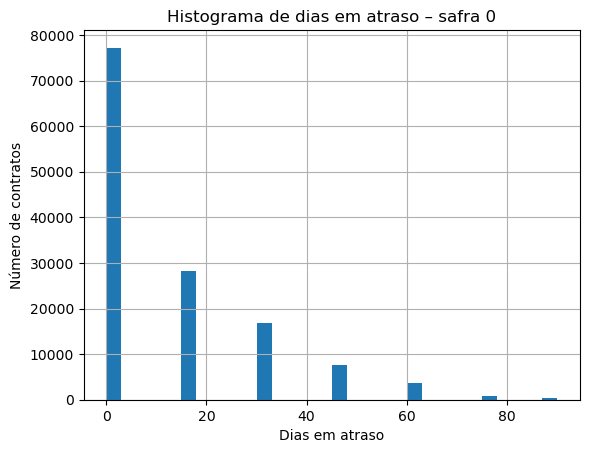

In [14]:
plt.figure()
balanced['dias_atraso'].hist(bins=30)
plt.xlabel('Dias em atraso')
plt.ylabel('Número de contratos')
plt.title('Histograma de dias em atraso – safra 0')
plt.show()

In [ ]:
df_snapshot.shape